# Energy usage analysis of meter readings using Pandas
- Load file one date and meter reading per line
- Use regexp to parse these and create a dataframe
- Readings are on random dates so resample to interpolate to daily and plot
- Resample daily to monthly and look at usage per month

In [1]:
import pandas as pd
import re
import dateparser

In [2]:
with open('meter_readings.txt') as f:
    raw = f.read()

In [3]:
raw

'13 Mar 2021You gave121381\n14 Nov 2020You gave117334\n01 Nov 2020You gave116656\n13 Oct 2020You gave115792\n26 Sep 2020You gave115113\n30 Aug 2020You gave113575\n23 Jul 2020You gave110968\n08 Jul 2020You gave110389\n08 Jun 2020You gave108896\n08 May 2020You gave107026\n06 May 2020You gave106789\n02 May 2020You gave106663\n26 Apr 2020You gave106534\n07 Apr 2020You gave105474\n04 Apr 2020You gave105293\n08 Mar 2020You gave104490\n08 Feb 2020You gave103233\n02 Feb 2020You gave102993\n05 Jan 2020You gave101570\n07 Dec 2019You gave100397\n03 Nov 2019You gave098981\n05 Oct 2019You gave097800\n04 Sep 2019You gave096029\n08 Jul 2019You gave086371\n16 Jun 2019You gave085284\n20 Apr 2019You gave083902\n03 Mar 2019You gave082402\n07 Feb 2019You gave081396\n13 Oct 2018You gave078143\n16 Sep 2018You gave077246\n05 Jul 2018You gave073068\n31 Mar 2018You gave066813\n08 Oct 2017You gave063209\n10 Feb 2017 045875\n23 Oct 2016 041947\n01 Jun 2016 032748\n24 Feb 2016 028577\n08 Aug 2015You gave024300\n1

In [4]:
readings = re.findall("(\d\d \w{3} \d{4}).*(\d{6})", raw)

In [5]:
df = pd.DataFrame([(dateparser.parse(d), int(r)) for d,r in readings], columns=['Date', 'Reading'])
df = df.set_index('Date')

In [6]:
rng = pd.date_range(df.index.min(), df.index.max())
daily = df.reindex(rng).interpolate(method='time')

<AxesSubplot:>

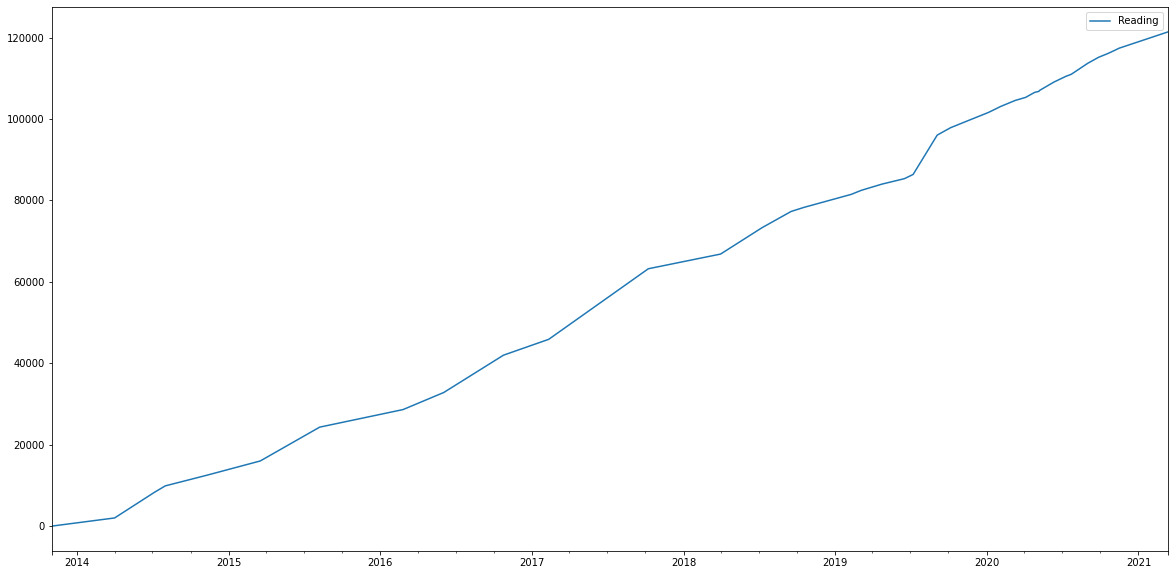

In [7]:
daily.plot(figsize=(20,10))

In [8]:
monthly = daily.resample('M').last()

In [9]:
def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month

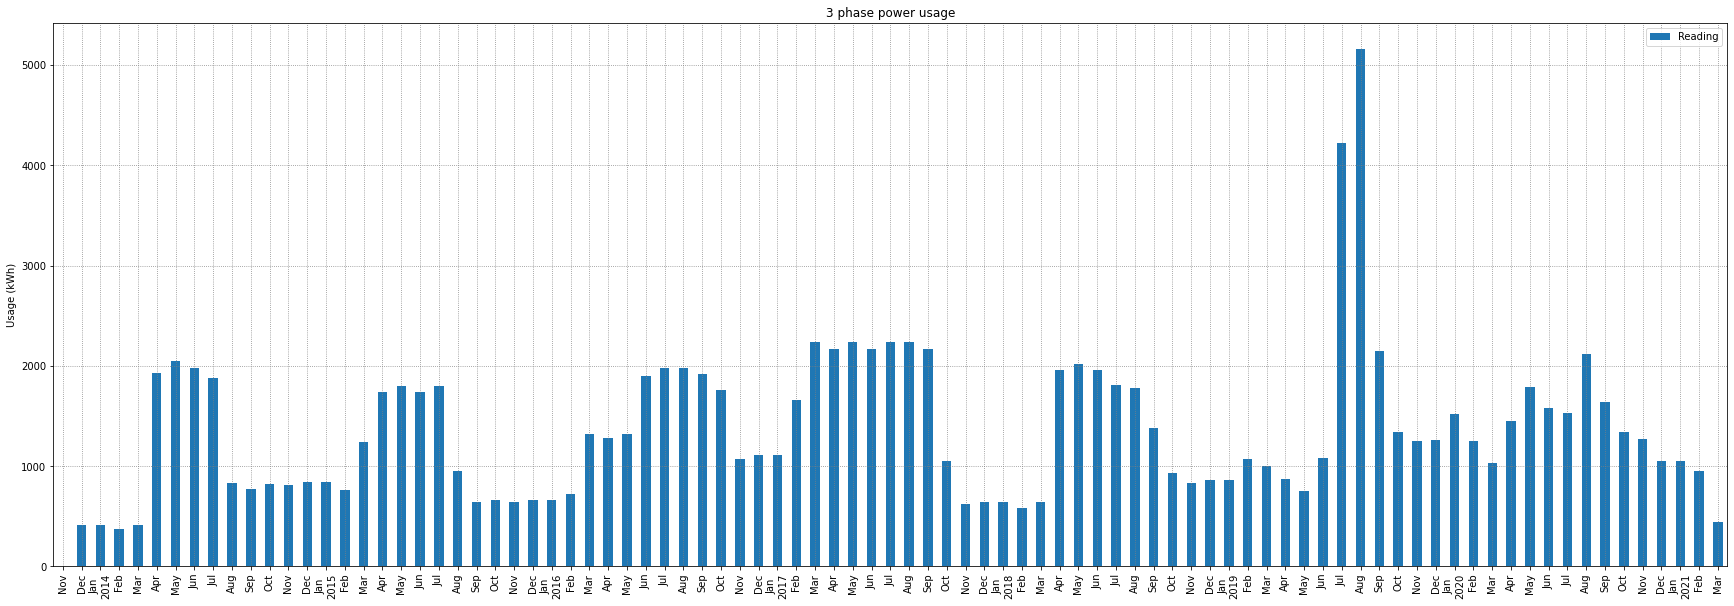

In [12]:
ax = monthly.diff().plot.bar(figsize=(30,10), title='3 phase power usage', grid=True)
ax.set_ylabel('Usage (kWh)')
ax.set_xticklabels(map(line_format, monthly.index))
ax.grid(zorder=0)
ax.grid(b=True, color='gray', linestyle=':')